In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import time
from numpy import linalg
hdu_list = fits.open('specgrid.fits')
logwave = hdu_list['LOGWAVE'].data
flux = hdu_list['FLUX'].data

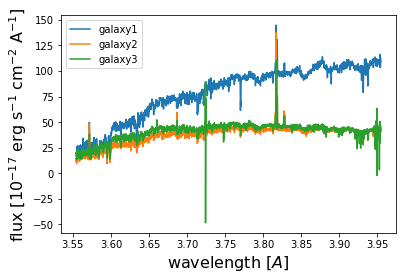

In [44]:
for i in range(3):
    lab = str(i+1)
    plt.plot(logwave, flux[i],label='galaxy'+lab)
plt.ylabel('flux [$10^{−17}$ erg s$^{−1}$ cm$^{−2}$ A$^{-1}$]', fontsize = 16)
plt.xlabel('wavelength [$A$]', fontsize = 16)
plt.legend()
plt.savefig('fig1.png')
plt.show()

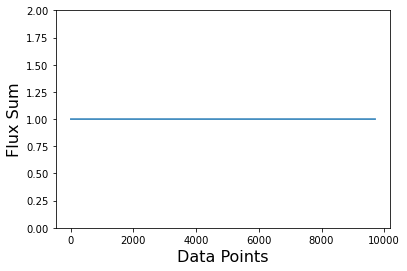

In [3]:
flux_sum = np.sum(flux, axis = 1)
flux_normalized = flux/np.tile(flux_sum, (np.shape(flux)[1], 1)).T
plt.plot(np.sum(flux_normalized, axis = 1))
plt.ylabel('Flux Sum', fontsize = 16)
plt.xlabel('Data Points',fontsize=16)
plt.ylim(0,2)
plt.savefig('fig2.png')
plt.show()

means_normalized = np.mean(flux_normalized, axis=1)
flux_normalized_0_mean = flux_normalized-np.tile(means_normalized, (np.shape(flux)[1], 1)).T

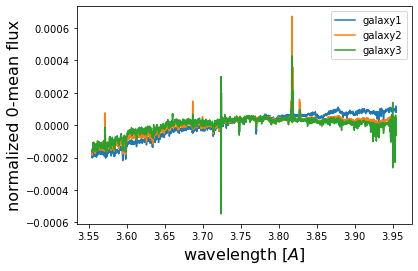

In [46]:
for i in range(3):
    lab = str(i+1)
    plt.plot(logwave, flux_normalized_0_mean[i],label='galaxy'+lab)
plt.ylabel('normalized 0-mean flux', fontsize = 16)
plt.xlabel('wavelength [$A$]', fontsize = 16)
plt.legend()
plt.savefig('fig3.png')
plt.show()

In [5]:
def sorted_eigs(r, return_eigvalues = False):
    """
    Calculate the eigenvectors and eigenvalues of the correlation matrix of r
    -----------------------------------------------------
    """
    corr=r.T@r
    eigs=np.linalg.eig(corr) #calculate eigenvectors and values of original 
    arg=np.argsort(eigs[0])[::-1] #get indices for sorted eigenvalues
    eigvec=eigs[1][:,arg] #sort eigenvectors
    eig = eigs[0][arg] # sort eigenvalues
    if return_eigvalues == True:
        return eig, eigvec
    else:
        return eigvec

In [6]:
t1=time.time()
eigvals_pca, eigvecs_pca = sorted_eigs(flux_normalized_0_mean, return_eigvalues = True)
t2=time.time()
print('Time for PCA is',str(t2-t1),'s')

Time for PCA is 18.518712043762207 s


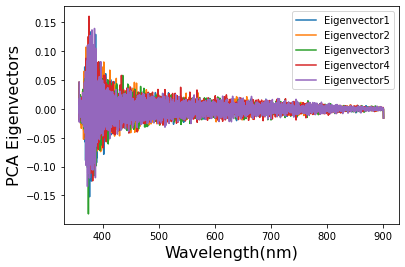

In [7]:
wave = (10**logwave)/10
for i in np.arange(5):
    lab=str(i+1)
    plt.plot(wave, eigvecs_pca.T[:,i],label='Eigenvector'+lab)
    plt.xlabel('Wavelength(nm)', fontsize=16)
    plt.ylabel('PCA Eigenvectors', fontsize=16)
    plt.legend()
plt.savefig('fig4.png')

In [9]:
t3=time.time()
(u, w, vt) = linalg.svd(flux_normalized_0_mean, full_matrices=True)
eigvecs_svd = vt.T
eigvals_svd = w**2
svd_sort = np.argsort(eigvals_svd)[::-1]
eigvecs_svd = eigvecs_svd[:,svd_sort]
eigvals_svd = eigvals_svd[svd_sort]
t4=time.time()
print('Time for SVD is',str(t4-t3),'s')

Time for SVD is 19.78552222251892 s


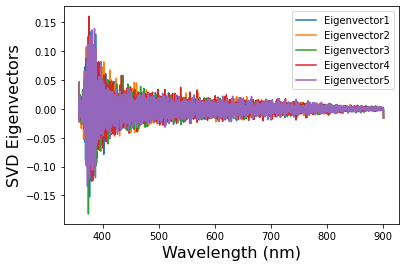

In [10]:
for i in range(5):
    lab=str(i+1)
    plt.plot(wave, eigvecs_pca.T[:,i],label='Eigenvector'+lab)
    plt.xlabel('Wavelength (nm)', fontsize=16)
    plt.ylabel('SVD Eigenvectors', fontsize=16)
    plt.legend()
plt.savefig('fig5.png')

In [15]:
print("Condition number C:", np.abs(max(eigvals_pca)/min(eigvals_pca)))
print("Condition number R:", np.max(w)/np.min(w))

Condition number C: 15052990000.0
Condition number R: 6561841.5


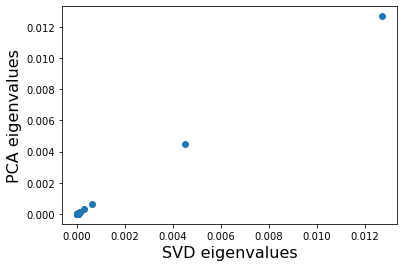

In [48]:
plt.plot(eigvals_svd, eigvals[:1000], 'o')
plt.xlabel('SVD eigenvalues', fontsize = 16)
plt.ylabel('PCA eigenvalues', fontsize = 16)
plt.savefig('fig6.png')

In [24]:
def PCA(l, r, project = True):
    """
    Perform PCA dimensionality reduction
    --------------------------------------------------------------------------------------
    """
    eigvector = sorted_eigs(r)
    eigvec=eigvector[:,:l] #sort eigenvectors, only keep l
    reduced_wavelength_data= np.dot(eigvec.T,r.T) #np.dot(eigvec.T, np.dot(eigvec,r.T))
    if project == False:
        return reduced_wavelength_data.T # get the reduced wavelength weights
    else: 
        return np.dot(eigvec, reduced_wavelength_data).T # multiply eigenvectors by 
                                                        # weights to get approximate spectrum

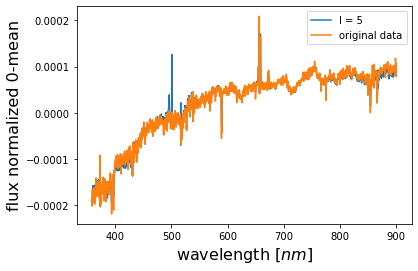

In [28]:
PCA_spectra = PCA(5,flux_normalized_0_mean,project = True)
plt.plot(wave, PCA_spectra[0,:], label = 'l = 5')
plt.plot(wave, flux_normalized_0_mean[0,:], label = 'original data')
plt.ylabel('flux normalized 0-mean', fontsize = 16)
plt.xlabel('wavelength [$nm$]', fontsize = 16)
plt.legend()
plt.savefig('fig7.png')
plt.show()

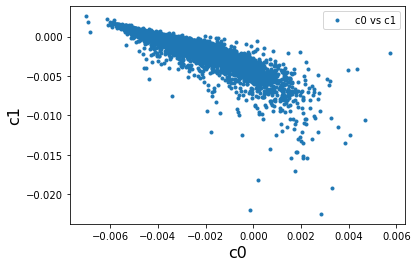

In [35]:
w1 = PCA(5,r,project = False)
c_0 = w1[:,0].T
c_1 = w1[:,1].T
c_2 = w1[:,2].T
plt.plot(c_0, c_1, '.',label = 'c0 vs c1')
plt.ylabel('c1', fontsize = 16)
plt.xlabel('c0', fontsize = 16)
plt.legend()
plt.savefig('fig8.png')
plt.show()

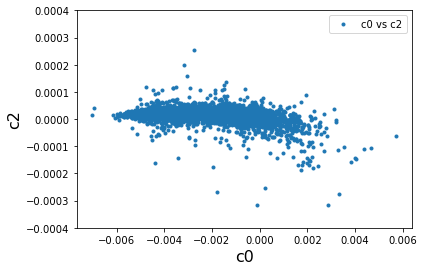

In [37]:
plt.plot(c_0, c_2, '.',label = 'c0 vs c2')
plt.ylim(-0.0004,0.0004)
plt.ylabel('c2', fontsize = 16)
plt.xlabel('c0', fontsize = 16)
plt.legend()
plt.savefig('fig9.png')
plt.show()

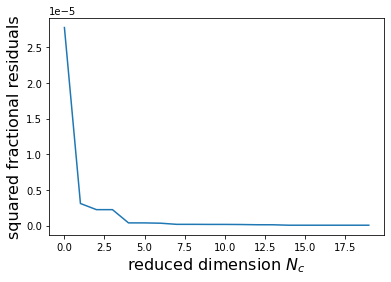

In [41]:
total_sq = []
for i in range(20):
    PCA_spec = PCA(i,r,project=True)
    total_sq.append(np.sum((PCA_spec[0,:]-flux_normalized_0_mean[0,:])**2))
plt.plot(range(20),total_sq)
plt.ylabel('squared fractional residuals', fontsize = 16)
plt.xlabel('reduced dimension $N_c$', fontsize = 16)
plt.savefig('fig10.png')
plt.show()

In [40]:
print('The fractional error is',total_sq[19])

The fractional error is 9.111186e-08
